In this competition your task will be to predict the probability for a tutor to be a proper one for preparing for the math exam. You will be given two datasets: train.csv (contains all features and the target) and test.csv (only features).

In [218]:
# You can only use these imports:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [219]:
df_train = pd.read_csv('./train.csv')

Проверка данных на пропуски

In [220]:
df_train.isna().sum()

Id                     0
age                    0
years_of_experience    0
lesson_price           0
qualification          0
physics                0
chemistry              0
biology                0
english                0
geography              0
history                0
mean_exam_points       0
choose                 0
dtype: int64

Соотношение количества целевых переменных

In [221]:
df_train['choose'].value_counts()

0    8891
1    1109
Name: choose, dtype: int64

Анализ данных

In [222]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


In [223]:
df_train.columns

Index(['Id', 'age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'chemistry', 'biology', 'english', 'geography', 'history',
       'mean_exam_points', 'choose'],
      dtype='object')

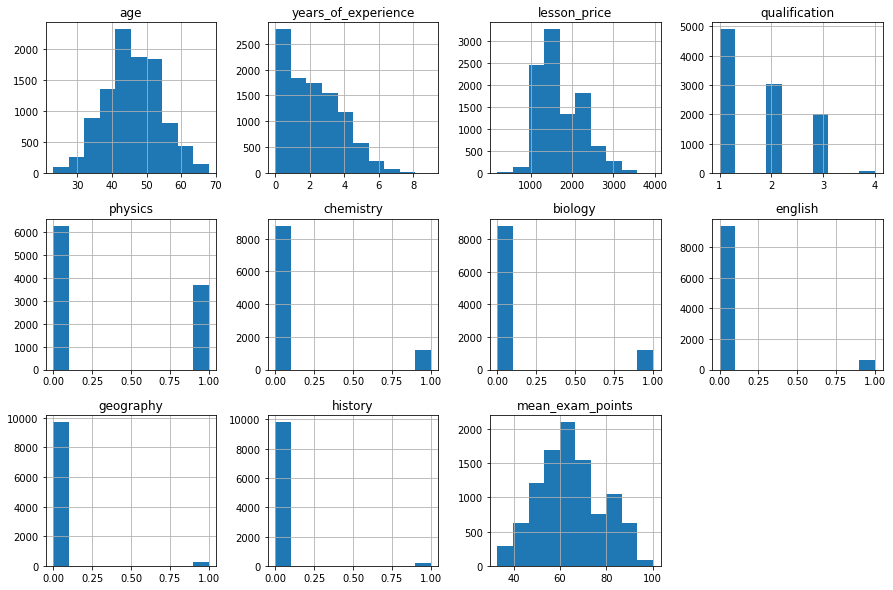

In [224]:
df_train[df_train.columns[1 : -1]].hist(bins=10, layout=(3, 4), figsize=(15, 10))
plt.show()

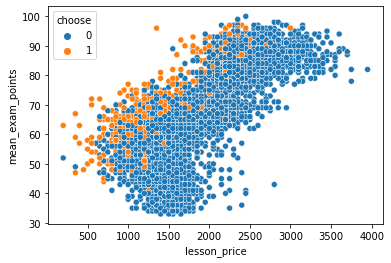

In [225]:
sns.scatterplot(data=df_train, x='lesson_price', y='mean_exam_points', hue='choose')
plt.show()

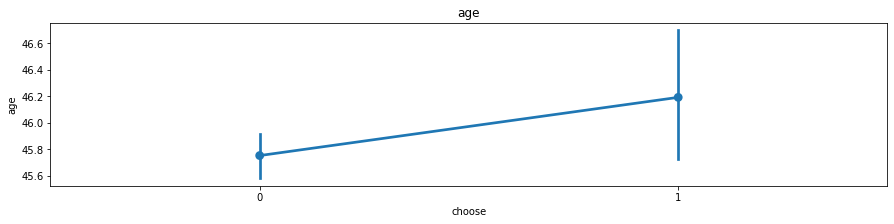

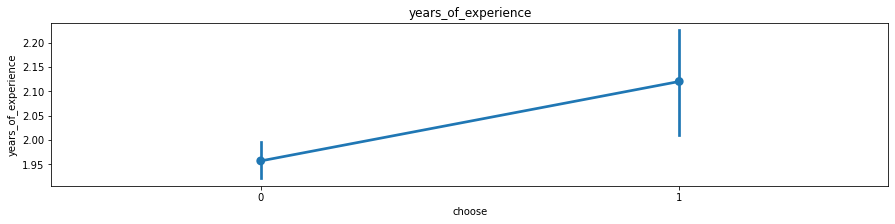

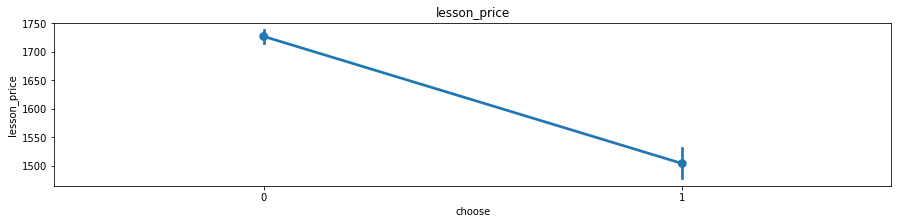

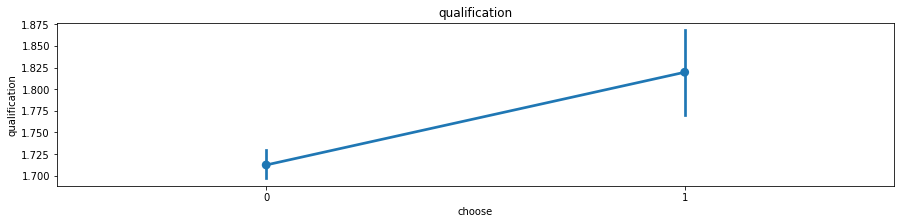

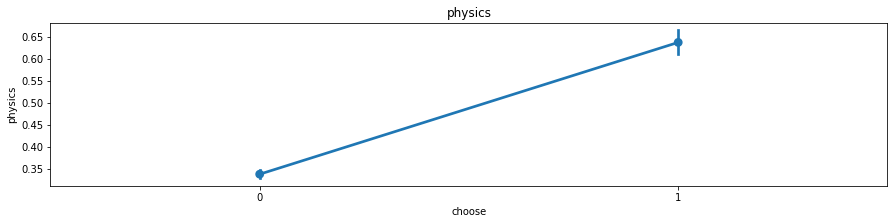

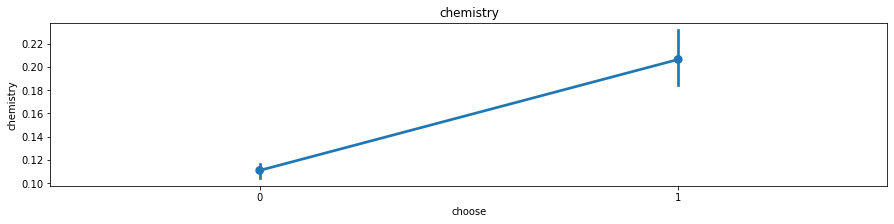

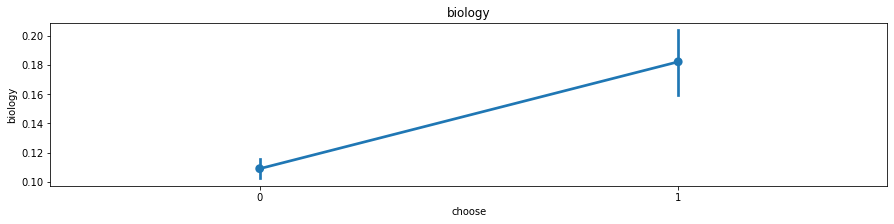

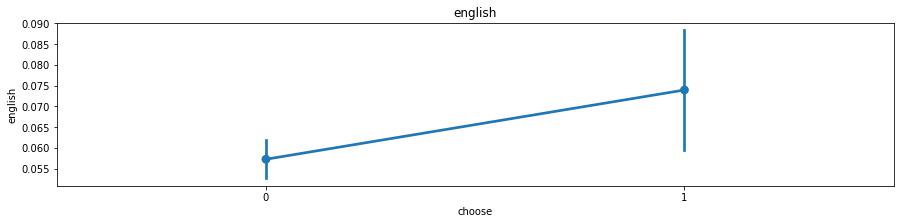

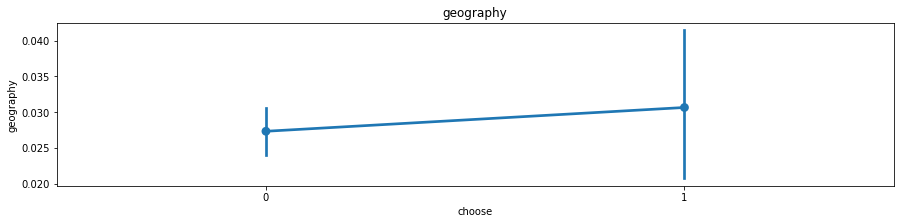

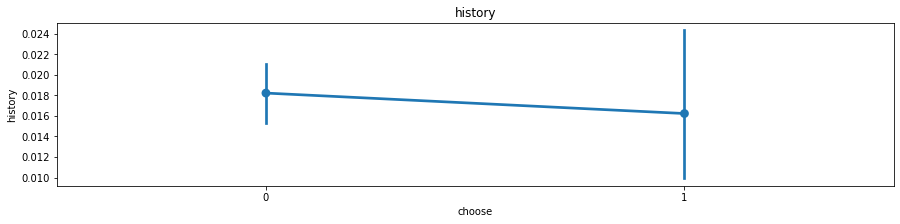

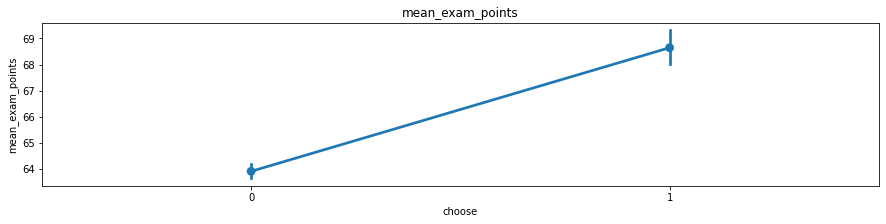

In [226]:
for feature in df_train.columns[1 : -1]:
    plt.figure(figsize=(15, 3))
    sns.pointplot(data=df_train, y=feature, x='choose')
    plt.title(feature)
    plt.show()

geography и history 

Выделение целевой переменной

In [227]:
y = df_train['choose']
y.shape

(10000,)

In [228]:
X = df_train.drop(columns=['Id','choose',
#                            'geography',
                           'history',
#                            'years_of_experience',
#                            'english',
                          ])
X.shape

(10000, 10)

Разбиение выборки на обучающую и тестовую

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True, stratify=y)

Балансировка классов

In [230]:
df = pd.concat([X_train, y_train], axis=1)
df_1 = df.loc[df['choose'] == 1]
for i in range(int(y_train.value_counts()[0] / y_train.value_counts()[1] - 1)):
    df = pd.concat([df, df_1])

In [231]:
df['choose'].value_counts()

0    6224
1    6208
Name: choose, dtype: int64

In [232]:
X_train = df.drop(columns=['choose'])
y_train = df['choose']

Построение и обучение модели на обучающей выборке с помощью модели Случайного леса

In [233]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    
    actual = actual.to_numpy()
    
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [234]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [235]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [236]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity


# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_samples_leaf=1):

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объекта
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_samples_leaf=1, max_depth=None, depth=0):

    quality, t, index = find_best_split(data, labels, min_samples_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
    if max_depth and depth >= max_depth:
        return Leaf(data, labels)
    
    depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_samples_leaf, max_depth, depth)
    false_branch = build_tree(false_data, false_labels, min_samples_leaf, max_depth, depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
    
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes



def random_forest(data, labels, n_trees, max_depth=None, min_samples_leaf=1):
    data = data.to_numpy()
    labels = labels.to_numpy()
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, min_samples_leaf, max_depth))
        
    return forest

In [237]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap


def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample


# предсказание голосованием деревьев

def tree_vote(forest, data):
    
    data = data.to_numpy()

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Подбор гиперпараметров

In [273]:
n_trees = 200
min_samples_leaf = [26] # 4, 12, 26, 35
max_depth = [9]

In [274]:
# for i in range(len(n_trees)):
test = []
train = []
for j in range(len(min_samples_leaf)):
    for i in range(len(max_depth)):

        print(f'\033[31m \n Глубина деревьев = {max_depth[i]}')
        print(f'\033[31m \n минимальное число в листе = {min_samples_leaf[j]}')
    #     print(f'\033[31m \n количество деревьев = {n_trees[i]}')
        my_forest = random_forest(X_train, y_train,
                                  n_trees,
                                  max_depth=max_depth[i],
                                  min_samples_leaf=min_samples_leaf[j]
                                 )
        train_answers = tree_vote(my_forest, X_train)
        test_answers = tree_vote(my_forest, X_test)

        train_accuracy = accuracy_metric(y_train, train_answers)
        print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
        test_accuracy = accuracy_metric(y_test, test_answers)
        print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

 
 Глубина деревьев = 9
 
 минимальное число в листе = 26


In [278]:
df_test = pd.read_csv('test.csv')
df_test.head(2)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,10000,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
1,10001,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0


In [279]:
submission = pd.read_csv('submission_example.csv')
submission.head(2)

,Id,choose
0,10000,0.5
1,10001,0.5


In [280]:
df_test.drop(columns=['Id',
#                       'geography',
                      'history',
#                       'years_of_experience'
                     ], inplace=True)

In [281]:
test_answers = tree_vote(my_forest, df_test)

In [282]:
df_answers = pd.DataFrame(test_answers)

In [283]:
submission = pd.concat([submission, df_answers], axis=1)
submission.drop(columns='choose', inplace=True)

In [284]:
submission.rename(columns={0 : 'choose'}, inplace=True)
submission

,Id,choose
0,10000,0.0
1,10001,1.0
2,10002,0.0
3,10003,0.0
4,10004,1.0
...,...,...
9995,19995,0.0
9996,19996,0.0
9997,19997,1.0
9998,19998,1.0


In [285]:
submission.to_csv('submission.csv', index=False)

In [286]:
submission['choose'].value_counts()

0.0    7071
1.0    2929
Name: choose, dtype: int64